In [4]:
import datetime

import colormaps
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr
from jetutils.anyspell import get_persistent_jet_spells, mask_from_spells_pl, subset_around_onset, get_persistent_spell_times_from_som, get_spells, extend_spells, gb_index, make_daily
from jetutils.clustering import Experiment, RAW_REALSPACE, labels_to_centers
from jetutils.data import DataHandler, open_da, data_path, compute_anomalies_pl, coarsen_da, compute_anomalies_ds
from jetutils.definitions import (
    DATADIR,
    FIGURES,
    PRETTIER_VARNAME,
    YEARS,
    KAPPA,
    compute,
    get_region,
    infer_direction,
    polars_to_xarray,
    xarray_to_polars,
    labels_to_mask,
    extract_season_from_df,
    DUNCANS_REGIONS_NAMES,
    UNITS,
    N_WORKERS,
    do_rle,
    do_rle_fill_hole,
    squarify,
)
from jetutils.jet_finding import JetFindingExperiment, jet_integral_haversine, find_all_jets, haversine_from_dl, jet_position_as_da, add_normals, gather_normal_da_jets, average_jet_categories, connected_from_cross, get_double_jet_index, iterate_over_year_maybe_member, track_jets, average_jet_categories_v2, spells_from_cross, spells_from_cross_catd
from jetutils.plots import COLORS, COLORS_EXT, PINKPURPLE, WERNLI_FLAIR, WERNLI_FLAIR_LEVELS, Clusterplot, gather_normal_da_jets_wrapper, _gather_normal_da_jets_wrapper, make_transparent, honeycomb_panel, plot_seasonal, interp_jets_to_zero_one
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from pathlib import Path
from tqdm import tqdm
import polars.selectors as cs


%load_ext autoreload
%autoreload 2
%matplotlib inline

Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  10
Guessed MEMORY_LIMIT :  225280


In [5]:
summer_filter = (
    pl.datetime_range(
        start=pl.datetime(1959, 1, 1),
        end=pl.datetime(2023, 1, 1),
        closed="left",
        interval="6h",
        eager=True,
        time_unit="ms",
    )
    .rename("time")
    .to_frame()
    .filter(pl.col("time").dt.ordinal_day() >= 166, pl.col("time").dt.ordinal_day() < 260)
)
summer = summer_filter["time"]
summer_daily = summer.filter(summer.dt.hour() == 0)
dh = DataHandler("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/high_wind/6H/results/7")
exp = JetFindingExperiment(dh)
ds = exp.ds
all_jets_one_df = exp.find_jets(force=False, alignment_thresh=0.6, base_s_thresh=0.55, int_thresh_factor=0.35, hole_size=10)
all_jets_one_df = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=5, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})

props_uncat = exp.props_as_df(False).cast({"time": pl.Datetime("ms")})
props_as_df = average_jet_categories(props_uncat, polar_cutoff=0.5)

props_summer = summer_filter.join(props_as_df, on="time")
phat_filter = (pl.col("is_polar") < 0.5) | ((pl.col("is_polar") > 0.5) & (pl.col("int") > 2e8))

phat_jets = all_jets_one_df.filter((pl.col("is_polar").mean().over(["time", "jet ID"]) < 0.5) | ((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5) & (pl.col("int").mode().first().over(["time", "jet ID"]) > 2e8)))
phat_jets_catd = phat_jets.with_columns(**{"jet ID": (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.UInt32())})
phat_props = props_uncat.filter(phat_filter)
phat_props_catd = average_jet_categories(phat_props, polar_cutoff=0.5)

In [6]:
diffs = (
    phat_props_catd[["jet", "time", "mean_lon", "mean_lat"]]
    .group_by("jet")
    .agg(
        pl.col("time"),
        cs.numeric().diff().abs(),
        (
            pl.col("time").diff().cast(pl.Float32())
            / pl.duration(
                seconds=1, time_unit=props_as_df["time"].dtype.time_unit
            ).cast(pl.Float32())
        ).alias("dt"),
        pl.col("mean_lat").alias("actual_lat"),
    )
    .explode(cs.all().exclude("jet"))
    .sort("time", "jet", descending=[False, True])
    .with_columns(
        com_speed=(
            haversine_from_dl(pl.col("actual_lat"), pl.col("mean_lon"), pl.col("mean_lat"))
            / pl.col("dt")
        )
        .cast(pl.Float32())
    )
    .rolling("time", period="2d", offset="-1d", group_by="jet")
    .agg(pl.col("com_speed").mean())
)
phat_props_catd = phat_props_catd.join(diffs[["time", "jet", "com_speed"]], on=["time", "jet"])
phat_props_catd_summer = summer_filter.join(phat_props_catd, on="time")
# cross_phat = track_jets(phat_jets, n_next=1)
# cross_phat.write_parquet(exp.path.joinpath("cross_phat.parquet"))
# cross_catd = track_jets(phat_jets_catd, n_next=1)
# cross_catd.write_parquet(exp.path.joinpath("cross_catd.parquet"))

cross_phat = pl.read_parquet(exp.path.joinpath("cross_phat.parquet"))
cross_catd = pl.read_parquet(exp.path.joinpath("cross_catd.parquet"))
cross_catd = squarify(summer_filter.join(cross_catd[["jet ID"]].unique("jet ID"), how="cross").join(cross_catd, on=["time", "jet ID"], how="left"))

spells_list = spells_from_cross(phat_jets, cross_phat, dis_polar_thresh=0.15, dist_thresh=2e5, season=summer, q_STJ=0.988, q_EDJ=0.984)
spells_list_catd = spells_from_cross_catd(cross_catd, season=summer, q_STJ=0.81, q_EDJ=0.7, minlen=datetime.timedelta(days=4))

spells_from_jet_daily_stj_cs = get_persistent_jet_spells(
    phat_props_catd_summer,
    "com_speed",
    jet="STJ",
    q=0.842,
    minlen=datetime.timedelta(days=5),
    fill_holes=datetime.timedelta(hours=24),
).with_columns(spell_of=pl.lit("STJ"))
spells_from_jet_daily_edj_cs = get_persistent_jet_spells(
    phat_props_catd_summer,
    "com_speed",
    jet="EDJ",
    q=0.857,
    minlen=datetime.timedelta(days=5),
    fill_holes=datetime.timedelta(hours=24),
).with_columns(spell_of=pl.lit("EDJ"))
spells_list = spells_list | {
    "STJ_com": spells_from_jet_daily_stj_cs.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}),
    "EDJ_com": spells_from_jet_daily_edj_cs.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}),
}
spells_list = spells_list | {f"{key}_catd": val for key, val in spells_list_catd.items()}

for name, spell in spells_list.items():
    print(name, spell["spell"].n_unique())

kwargs = dict(time_before=datetime.timedelta(hours=24), time_after=datetime.timedelta(hours=24))
daily_spells_list = {a: make_daily(b, "spell", ["len", "spell_of"]) for a, b in spells_list.items()}

STJ 24
EDJ 26
STJ_com 26
EDJ_com 26
STJ_catd 26
EDJ_catd 24


In [4]:
from scipy.stats import norm, chi2, t
from string import ascii_lowercase
from functools import partial 
data_vars = [
    "mean_lat",
    "mean_theta",
    "mean_s",
    "width",
    "tilt",
    "waviness1",
    "mean_lat:var",
    "mean_s:var",
    "is_polar",
]
mode_dict = {
    "": "Connected components",
    "catd": "Full distance",
    "com": "COM distance",
}

def func(col):
    if col[-3:] == "var":
        return pl.col(col.split(":")[0]).var()
    return pl.col(col).mean()


def mean_confidence(col: pl.Series, q: float) -> pl.Series:
    n = (col.is_not_null() & col.is_not_nan()).sum()
    mu = col.mean()
    s_sq = col.var()
    if s_sq is None:
        return None
    s = np.sqrt(s_sq)
    sign = 1 - 2 * int(q < 0.5)
    q = q if q < 0.5 else 1 - q
    if n > 10:
        to_ret = mu + sign * np.abs(norm.ppf(q=q)) / np.sqrt(n) * s
    else:
        to_ret = mu + sign * s / np.sqrt(n) * t.ppf(q=1 - q, df=n - 1)
    to_ret = np.clip(to_ret, 0, mu + 5 * s)
    return to_ret


def var_confidence(col: pl.Series, q) -> float:
    n = (col.is_not_null() & col.is_not_nan()).sum()
    s_sq = col.var()
    if s_sq is None:
        return None
    sign = 1 - 2 * int(q < 0.5)
    if n > 50:
        q = q if q < 0.5 else 1 - q
        to_ret = s_sq + sign * np.sqrt(2 / n) * np.abs(norm.ppf(q)) * s_sq
    else:
        to_ret = (n - 1) * s_sq / chi2.ppf(1 - q, df=n - 1)
    return np.clip(to_ret, 0, s_sq * 2)
        
    
def func_q(col, q):
    if col[-3:] == "var":
        return pl.col(col.split(":")[0]).map_batches(partial(var_confidence, q=q), return_dtype=pl.Float64())
    return pl.col(col).map_batches(partial(mean_confidence, q=q), return_dtype=pl.Float64())
    

q_mean = 1e-15
for spell_of in ["STJ" ,"EDJ", "STJ_catd" ,"EDJ_catd", "STJ_com" ,"EDJ_com"]:
# for spell_of in ["STJ_catd" ,"EDJ_catd"]:
    spells_from_jet = spells_list[spell_of]
    props_masked = mask_from_spells_pl(spells_from_jet, phat_props_catd, time_before=datetime.timedelta(days=4))
    props_masked = props_masked.filter(pl.col("spell").n_unique().over("relative_index") > 8)
    aggs = {col: func(col) for col in data_vars}
    aggs = aggs | {f"{col}_10": func_q(col, q_mean) for col in data_vars}
    aggs = aggs | {f"{col}_90": func_q(col, 1 - q_mean) for col in data_vars}
    explode_list = [f"{col}_10" for col in data_vars] + [f"{col}_90" for col in data_vars]
    aggs = aggs | {"alive": pl.col("time").len()}
    mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs).explode(explode_list)
    aggs_ = {col: func_q(col, 0.95) for col in data_vars}
    q25 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs_).explode(list(aggs_))
    aggs_ = {col: func_q(col, 0.05) for col in data_vars}
    q75 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs_).explode(list(aggs_))
    fig, axes = plt.subplots(3, 3, figsize=(11, 11), tight_layout=False, sharex="all")
    axes = axes.ravel()
    means = phat_props_catd_summer.group_by("jet", maintain_order=True).agg(**aggs)
    alive_spells = props_masked.group_by("relative_index").agg(pl.col("spell").n_unique()).sort("relative_index")["spell"].to_numpy()
    for j, jet in enumerate(["STJ", "EDJ"]):
        to_plot = mean_ps.filter(pl.col("jet") == jet)
        q25_ = q25.filter(pl.col("jet") == jet)
        q75_ = q75.filter(pl.col("jet") == jet)
        x = to_plot["relative_index"].unique().to_numpy() / 4
        for ax, data_var, letter in zip(axes, data_vars, ascii_lowercase):
            factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
            factor = 1e5 if data_var == "width" else factor
            ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j], lw=2.5)
            ax.fill_between(x, q25_[data_var] / factor, q75_[data_var] / factor, color=COLORS[2 - j], alpha=0.4)
            mean = means.filter(pl.col("jet")==jet)[data_var].item() / factor
            q10 = means.filter(pl.col("jet")==jet)[f"{data_var}_10"].item() / factor
            q90 = means.filter(pl.col("jet")==jet)[f"{data_var}_90"].item() / factor
            ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed", lw=2)
            if j == 0:
                factor_str = "" if factor == 1 else rf"$10^{int(np.log10(factor))} \times $"
                ax.set_title(
                    rf"{ascii_lowercase}) {PRETTIER_VARNAME.get(data_var, data_var)} [{factor_str}{UNITS.get(data_var, '~')}]"
                )
            ax.yaxis.set_major_locator(MaxNLocator(4, integer=True))
    for i, ax in enumerate(axes):
        ax.axvline(0, zorder=1, color="black", lw=2)
        if i > 5:
            ax.set_xlabel("Relative time around onset [days]", color="black")
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ybounds = [ylim[0] - 0.05 * (ylim[1] - ylim[0]), ylim[0] + 0.05 * (ylim[1] - ylim[0])]
        im = ax.pcolormesh(
            x, ybounds, alive_spells[None, :-1], zorder=-10,
            cmap=colormaps.greys, alpha=0.7
        )
    fig.set_constrained_layout(True)
    mode = mode_dict[spell_of[4:]]
    fig.suptitle(f"Persistent episodes of the {spell_of[:3]}. Mode: {mode}. {props_masked['spell'].n_unique()} spells")
    fig.savefig(f"{FIGURES}/jet_persistence/{spell_of}_props.png")
    plt.close()

# grams weather regimes

In [8]:
dh = DataHandler.from_specs("ERA5", "plev", "z", "6H", "all", [6, 7, 8, 9], -80, 40, 15, 80, 500, "dayofyear", {"dayofyear": ("win", 15)}, None)
exp_z = Experiment(dh)
centers_z, labels_z = exp_z.do_kmeans(4, 30, weigh_grams=False)

coslat = np.cos(np.deg2rad(centers_z.lat))
Pwr = (exp_z.da * centers_z * coslat).sum(["lon", "lat"]) / coslat.sum() / centers_z.lon.shape[0]
Iwr = (Pwr - Pwr.mean("time")) / Pwr.std("time", ddof=0)
Iwr = compute(Iwr)
Iwr = xarray_to_polars(Iwr.rename("Iwr")).drop("ratio", "label")

# Iwr = Iwr.with_columns(year=pl.col("time").dt.year())
sigma_wr = Iwr["Iwr"].std()
winner = Iwr.group_by("time", maintain_order=True).agg(pl.col("Iwr").arg_max().alias("winner"), pl.col("Iwr").max(), pl.col("time").dt.year().alias("year").first())
winner = winner.with_columns(winner=pl.when(pl.col("Iwr") > sigma_wr).then(1 + pl.col("winner")).otherwise(pl.lit(0)))
start_of_year = winner.group_by("year", maintain_order=True).len().with_columns(start_of_year=pl.col("len").cum_sum() - pl.col("len").get(0)).drop("len")
to_zero = (
    winner
    .group_by("year", maintain_order=True)
    .agg(pl.col("winner").rle().alias("rle"))
    .explode("rle")
    .unnest("rle")
    .group_by("year", maintain_order=True)
    .agg(
        len=pl.col("len"),
        start=pl.lit(0).append(
            pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)
        ),
        value=pl.col("value"),
    )
    .explode(["len", "start", "value"])
    .join(start_of_year, on="year")
    .with_columns(start=pl.col("start") + pl.col("start_of_year"))
    .drop("start_of_year")
    .filter(pl.col("len") < 20, pl.col("value") > 0)
    .drop("value")
    .with_columns(
        index=pl.int_ranges(pl.col("start"), pl.col("start") + pl.col("len"))
    )
    .drop("len", "start")
    .explode("index")
)[:, "index"]
winner[to_zero, "winner"] = 0

mask_updated = labels_to_mask(winner[:, "winner"].to_numpy())

s_and_z = (mask[:, :, None] & mask_updated[:, None, :])

[########################################] | 100% Completed | 20m 19s
time


100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


NameError: name 'mask' is not defined

# Jet relative stuff

In [4]:
args = ["all", [6, 7, 8, 9], *get_region(ds), "all"]
da_T = DataHandler.from_specs(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    *args,
).da
da_T = compute(da_T.sel(time=summer_daily), progress_flag=True)
da_T_upper = DataHandler.from_specs(
    "ERA5",
    "plev",
    "t300",
    "dailymean",
    *args,
).da
da_T_upper = compute(da_T_upper.sel(time=summer_daily), progress_flag=True)
da_tp = DataHandler.from_specs(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    *args,
).da
da_tp = compute(da_tp.sel(time=summer_daily), progress_flag=True)
da_pv = DataHandler.from_specs(
    "ERA5",
    "thetalev",
    "PV350",
    "dailymean",
    *args,
).da
da_pv = compute(da_pv.sel(time=summer_daily), progress_flag=True)
da_theta2pvu = DataHandler.from_specs(
    "ERA5",
    "surf",
    "theta2PVU",
    "dailymean",
    *args,
).da
da_theta2pvu = compute(da_theta2pvu.sel(time=summer_daily), progress_flag=True)
varnames_rwb = ["APVO", "CPVO", "SAPVS", "SCPVS", "TAPVS", "TCPVS"]
das_rwb = {}
for var in varnames_rwb:
    das_rwb[var] = compute(open_da("ERA5", "thetalev", var, "dailyany", *args))

[############                            ] | 32% Completed | 1.11 s ms

[########################################] | 100% Completed | 2.92 s
[########################################] | 100% Completed | 2.92 sms
[########################################] | 100% Completed | 2.62 sms
[########################################] | 100% Completed | 2.72 sms
[########################################] | 100% Completed | 2.52 sms


In [5]:
from string import ascii_lowercase

basepath = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp")

def symmetrize_p(
    pvals: xr.DataArray | np.ndarray, direction: int, q: float
) -> np.ndarray:
    if direction == 0:
        return np.amin([pvals * 2, (1 - pvals) * 2], axis=0) < q
    if direction == 1:
        return np.asarray(pvals) > 1 - q
    return np.asarray(pvals) < q

clims = {
    "t2m": xr.open_dataarray(exp.path.joinpath("t2m_phat_catd_relative_clim.nc")),
    "t_up": xr.open_dataarray(exp.path.joinpath("t300_phat_catd_relative_clim.nc")),
    "tp": xr.open_dataarray(exp.path.joinpath("tp_phat_catd_relative_clim.nc")) * 1000,
    "pv": xr.open_dataarray(exp.path.joinpath("PV_phat_catd_relative_clim.nc")).rename("PV350_interp") * 1e6,
    "theta2pvu": xr.open_dataarray(exp.path.joinpath("theta2PVU_phat_catd_relative_clim.nc")),
} | {varname: xr.open_dataarray(exp.path.joinpath(f"{varname}_phat_catd_relative_clim.nc")) * 100 for varname in varnames_rwb}

raw_das = {
    "t2m": da_T,
    "t_up": da_T_upper,
    "tp": da_tp * 1000,
    "pv": da_pv * 1e6,
    "theta2pvu": da_theta2pvu,
} | {varname: das_rwb[varname] * 100 for varname in varnames_rwb}
    
long_names = {
    "t2m": "2m temperature",
    "t_up": "300 hPa temp.",
    "tp": "Daily accum. precip.",
    "pv": "Pot. vorticity",
    "theta2pvu": r"$\theta$ at 2PVU",
    "APVO": r"APVO freq",
    "CPVO": r"CPVO freq",
    "SAPVS": r"SAPVS freq",
    "SCPVS": r"SCPVS freq",
    "TAPVS": r"TAPVS freq",
    "TCPVS": r"TCPVS freq",
}

units = {
    "t2m": "K",
    "t_up": "K",
    "tp": "mm",
    "pv": "PVU",
    "theta2pvu": "K"
} | {varname: r"$\%$" for varname in varnames_rwb}


variables = {
    "theta2pvu:clim": [6, colormaps.amp, [330, 370]],
    "theta2pvu:anom": [8, colormaps.BlWhRe, [-4, 4]],
    "theta2pvu:clim_grad": [8, colormaps.BlWhRe, [-4, 4]],
    "theta2pvu:anom_grad": [8, colormaps.BlWhRe, [-2, 2]],
    "pv:clim": [9, WERNLI_FLAIR, [0, 10]],
    "pv:anom": [8, colormaps.BlWhRe, [-4, 4]],
    "pv:clim_grad": [8, colormaps.BlWhRe, [-.5, .5]],
    "pv:anom_grad": [8, colormaps.BlWhRe, [-.5, .5]],
    "t2m:clim": [6, colormaps.amp, [280, 300]],
    "t2m:anom": [8, colormaps.BlWhRe, [-4, 4]],
    "tp:clim": [10, colormaps.precip_11lev, [0, 8]],
    "tp:anom": [14, colormaps.precip4_diff_19lev, [-2, 2]],
}
for varname in varnames_rwb:
    if varname[-1] == "O":
        variables[f"{varname}:clim"] = [7, colormaps.matter, [0, 70]]
        variables[f"{varname}:anom"] = [8, colormaps.BlueWhiteOrangeRed, [-20, 20]]
    else:
        continue
        variables[f"{varname}:clim"] = [7, colormaps.matter, [0, 3]]
        variables[f"{varname}:anom"] = [8, colormaps.BlueWhiteOrangeRed, [-2, 2]]

 12%|█▎        | 2/16 [00:00<00:00, 16.24it/s]

100%|██████████| 16/16 [00:00<00:00, 24.89it/s]


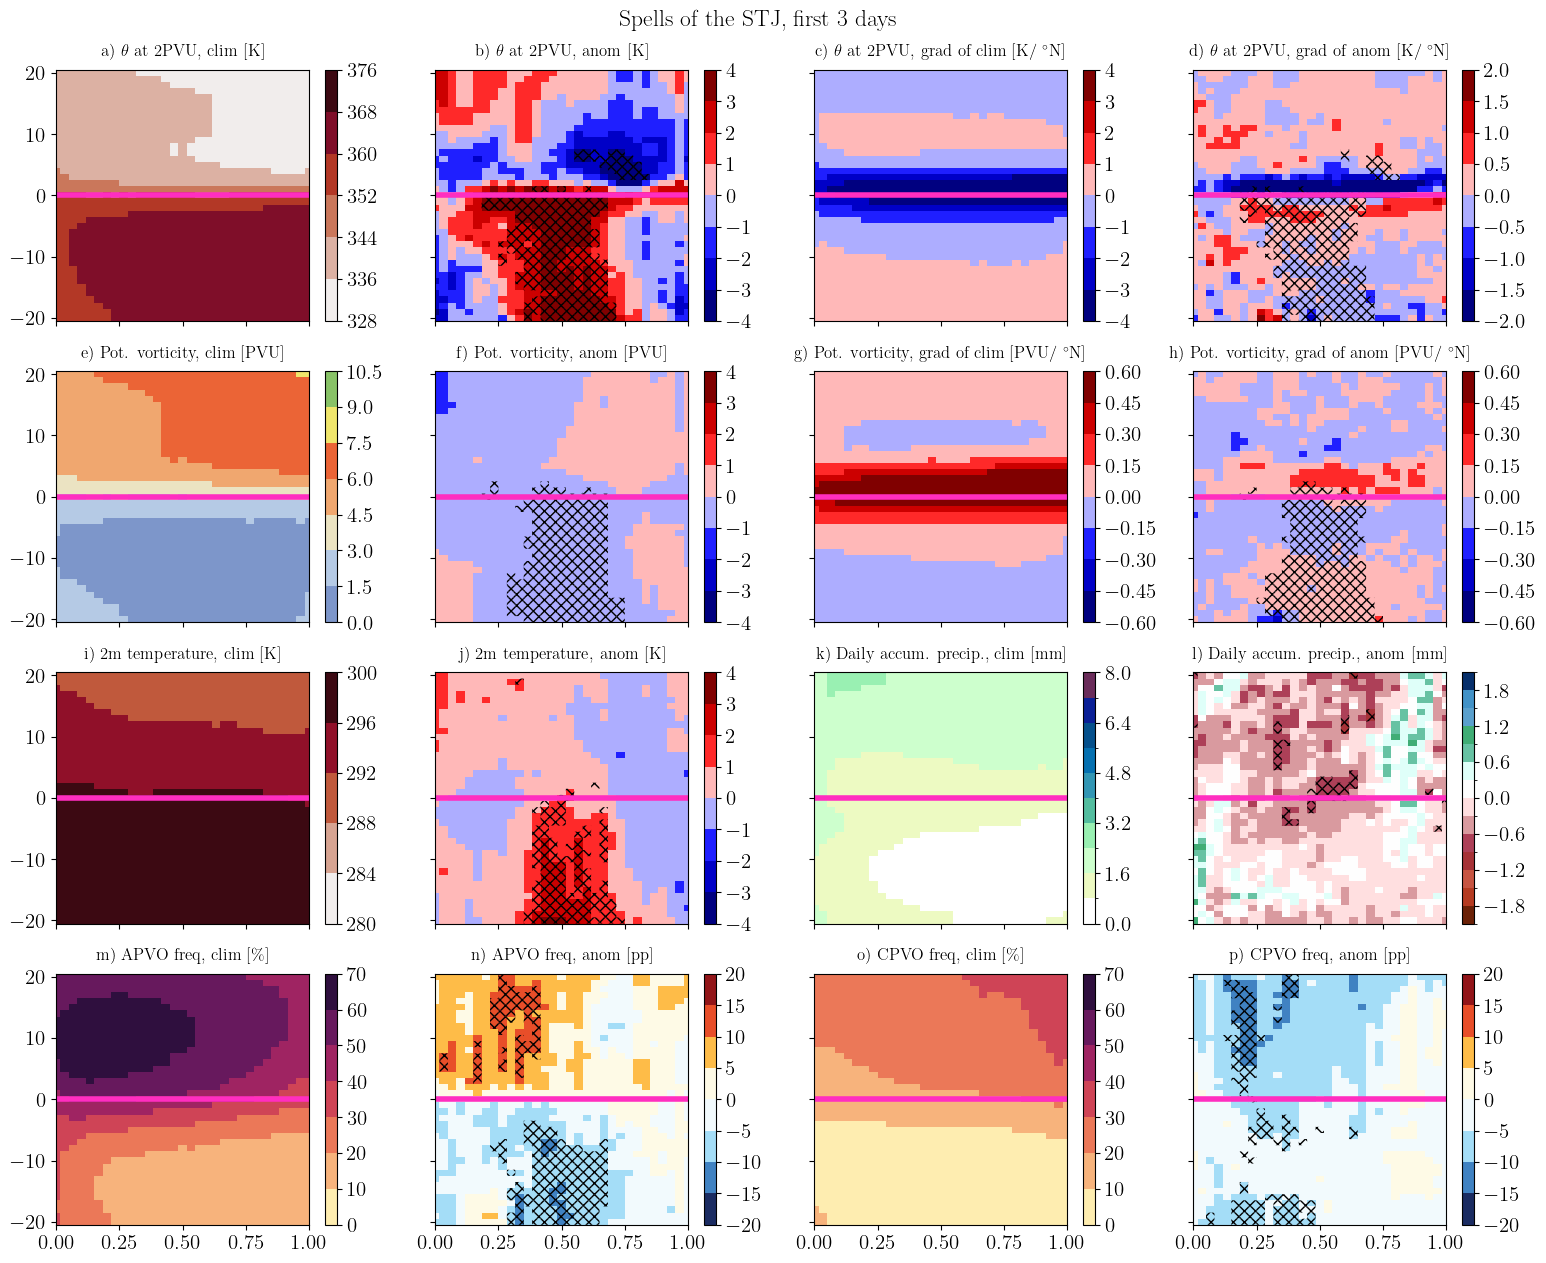

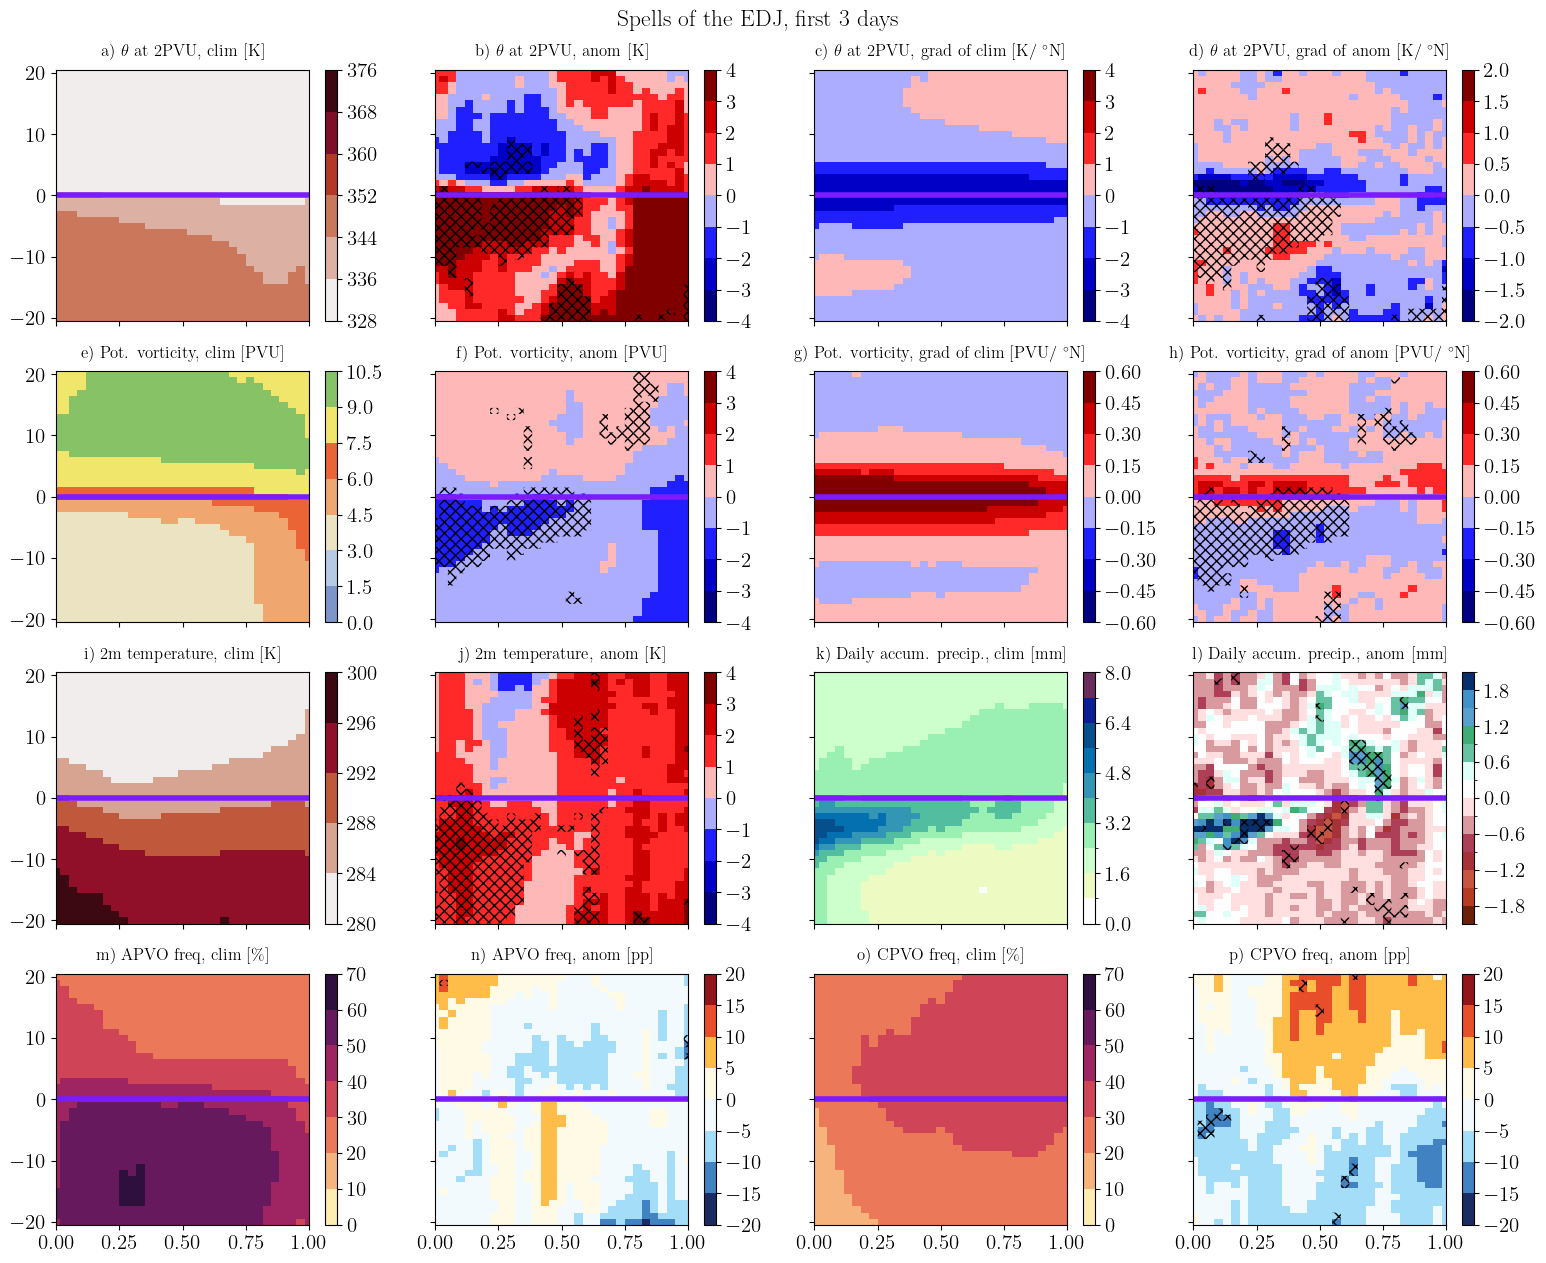

In [9]:
n_bootstraps = 200
days_around = [3]
basepath: Path = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp")
basepath.mkdir(exist_ok=True)
width = 15

for day_around in days_around:
    for spells_of in ["STJ_catd", "EDJ_catd"]:
        spells_from_jet = daily_spells_list[spells_of]
        spells_from_jet = extend_spells(spells_from_jet)
        spells_from_jet = subset_around_onset(spells_from_jet, around_onset=datetime.timedelta(days=day_around))
        jets = summer_daily.rename("time").to_frame().join(phat_jets_catd, on="time")
        times = spells_from_jet
        fig, axes = plt.subplots(4, 4, figsize=(width * 5 / 4, width), sharex="all", sharey="all")
        axes = axes.ravel()
        for i, ((varname, props), letter) in enumerate(zip(tqdm(variables.items()), ascii_lowercase)):
            ax = axes[i]
            nlevels, cmap, (min_, max_) = props
            varname, mode = varname.split(":")
            long_name = long_names[varname]
            grad = mode[-4:] == "grad"
            
            da = raw_das[varname]
            clim = clims[varname]
            
            if "jet ID" in times.columns:
                times = times.drop("jet ID")
            
            is_polar = spells_of[:3] == "EDJ"
            levels = MaxNLocator(nlevels).tick_values(min_, max_)
            norm = BoundaryNorm(levels, cmap.N)
            
            if mode in ["clim", "clim_grad"]:
                to_plot = clim.sel(dayofyear=slice(166, 260)).mean("dayofyear")
                pvals = None
            elif mode in ["anom", "anom_grad"]:
                ifile = basepath.joinpath(f"{varname}_{mode}_{spells_of}_da{day_around}.nc")
                ifile_pvals = basepath.joinpath(f"{varname}_{mode}_{spells_of}_da{day_around}_pvals.nc")
                if ifile.is_file() and ifile_pvals.is_file():
                    to_plot = xr.open_dataarray(ifile).transpose()
                    pvals = xr.open_dataarray(ifile_pvals)
                else:
                    to_plot = gather_normal_da_jets_wrapper(
                        jets, times, da, n_bootstraps=n_bootstraps, clim=clim
                    )
                    to_plot, pvals = to_plot[da.name + "_interp"], to_plot["pvals"]
                    to_plot.to_netcdf(ifile)
                    pvals.to_netcdf(ifile_pvals)
                    to_plot = to_plot.transpose()
                    pvals = pvals
            if grad:
                to_plot = to_plot.differentiate("n")
            im = ax.pcolormesh(to_plot.norm_index, to_plot.n, to_plot.sel(is_polar=is_polar).values, shading="nearest", cmap=cmap, norm=norm)
            if pvals is not None:
                direction = infer_direction(to_plot.sel(is_polar=is_polar))
                filter_ = symmetrize_p(pvals.sel(is_polar=is_polar).T, direction, 0.05)
                ax.pcolor(pvals.norm_index, pvals.n, pvals.sel(is_polar=is_polar).T.where(filter_), hatch="xxx", alpha=0.0)
            ax.plot([-.5, 1.5], [0, 0], lw=4, color=COLORS[2 - int(is_polar)])
            ax.set_xlim(0, 1)
            unit = units[varname] + r"$/~^{\circ} \mathrm{N}$" if grad else units[varname]
            unit = "pp" if unit == r"$\%$" and mode == "anom" else unit
            mode_pretty = mode.split("_")
            mode_pretty = f"{mode_pretty[1]} of {mode_pretty[0]}" if "_" in mode else mode
            ax.set_title(f"{letter}) {long_name}, {mode_pretty} [{unit}]", fontsize=12)
            fig.colorbar(im, ax=ax)
        fig.suptitle(f"Spells of the {spells_of[:3]}, first {f"{day_around} " if day_around > 1 else ''}day{'s' if day_around > 1 else ''}", y=0.92)
        fig.savefig(f"{FIGURES}/jet_persistence/{spells_of}_spells_composites_{day_around=}.png")

# Real space composites

In [ ]:
args1 = ["all", [6, 7, 8, 9], *get_region(ds)]
args2 = ["dayofyear", {"dayofyear": ("win", 15)}]
da_T_anom = DataHandler.from_specs(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    *args1,
    "all",
    *args2,
).da
da_T_anom = compute(da_T_anom, progress_flag=True)
da_tp_anom = DataHandler.from_specs(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    *args1,
    "all",
    *args2,
).da
da_tp_anom = compute(da_tp_anom, progress_flag=True)
da_T_up_anom = DataHandler.from_specs(
    "ERA5",
    "plev",
    "t300",
    "dailymean",
    *args1,
    "all",
    *args2,
).da
da_T_up_anom = compute(da_T_up_anom, progress_flag=True)
# da_theta2pvu = DataHandler.from_specs(
#     "ERA5",
#     "surf",
#     "theta2PVU",
#     "6H",
#     "all", [6, 7, 8, 9], *get_region(ds), "all"
# ).da
# da_theta2pvu = compute(da_theta2pvu, progress_flag=True)
# da_theta2pvu_anom = DataHandler.from_specs(
#     "ERA5",
#     "surf",
#     "theta2PVU",
#     "6H",
#     *args1,
#     "all",
#     *args2,
# ).da
# da_theta2pvu_anom = compute(da_theta2pvu_anom, progress_flag=True)
da_z200_anom = DataHandler.from_specs(
    "ERA5",
    "plev",
    "z",
    "6H",
    *args1,
    200,
    *args2,
).da
da_z200_anom = compute(da_z200_anom, progress_flag=False).rename("z200") / 9.8
da_z500_anom = DataHandler.from_specs(
    "ERA5",
    "plev",
    "z",
    "6H",
    *args1,
    500,
    *args2,
).da
da_z500_anom = compute(da_z500_anom, progress_flag=False).rename("z500") / 9.8
da_s = compute(ds["s"].sel(time=ds.time.dt.month.isin([6, 7, 8, 9])), progress_flag=True)

[########################################] | 100% Completed | 503.20 ms
[########################################] | 100% Completed | 605.19 ms
[########################################] | 100% Completed | 503.10 ms
[########################################] | 100% Completed | 11.05 s


In [23]:
long_names = {
    "t2m": "2m temperature [K]",
    "t_up": "Upper level temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
    "theta": "Upper-level Potential temperature [K]",
    "s": r"Wind speed [$m.s^{-1}$]",
    "theta2PVU": "Pot temp at 2 PVU [K]",
    "z200": "Z200 anomaly [m]",
    "z500": "Z500 anomaly [m]",
}

## clusterize

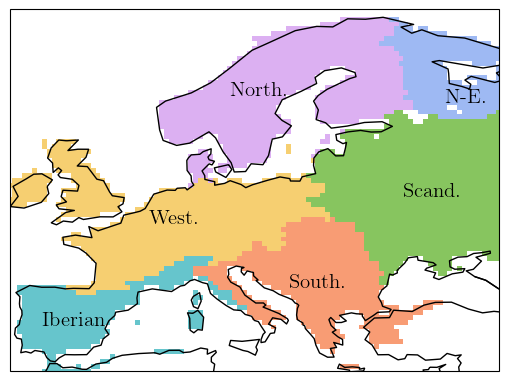

In [27]:
clusters_da = np.abs(xr.open_dataarray(Path(DATADIR, "ERA5/heatwaves_duncan/cluster_df.nc")).load())
clusters_da = clusters_da.interp(lat=np.arange(32, 72, 0.5), method="nearest")
clu = Clusterplot(1, 1, (-10, 40, 35, 72), row_height=5)
cmap = colormaps.pastel
ax = clu.axes[0]
unique_clusters = np.arange(1, 7)
norm = BoundaryNorm(np.arange(cmap.N) + 0.5, cmap.N)
clusters_da.assign_coords(lon=clusters_da.lon - clu.central_longitude).plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False
)
for j in range(6):
    lo = clusters_da.lon.where(clusters_da==(j + 1)).mean().item() - j - 2 * (j == 0) + 2 * (j == 2) + 1.5 * (j == 1) - (j == 4)  - clu.central_longitude
    la = clusters_da.lat.where(clusters_da==(j + 1)).mean().item() - (j == 5) * 2
    color = "black"
    ax.text(lo, la, DUNCANS_REGIONS_NAMES[j], ha="center", va="center", fontweight="bold", color=color)

plt.savefig(f"{FIGURES}/jet_persistence/regions.png")

In [30]:
from jetutils.anyspell import regionalize
region_T_ts = regionalize(da_T_anom, clusters_da, ["time"])
region_tp_ts = regionalize(da_tp_anom, clusters_da, ["time"])

In [33]:
region_T_ts.write_parquet("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/surf/t2m/dailymean/dayofyear_doywin15/results/1/regionalized.parquet")

In [35]:
region_tp_ts.write_parquet("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/surf/tp/dailysum/dayofyear_doywin15/results/1/regionalized.parquet")

## composites, all spells

In [34]:
from string import ascii_lowercase
plt.rc("axes", titlesize=13)
da = da_T_anom.copy().sel(lon=slice(-10, 40), lat=slice(30, 70))
cmap = colormaps.BlWhRe
plot_kwargs = {"cmap": cmap, "levels": 7}
Path(f"{FIGURES}/jet_persistence/realspace_stuff").mkdir(exist_ok=True)
nrow, ncol = 3, 2
n = nrow * ncol
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    clu = Clusterplot(nrow, ncol, get_region(da))
    spells_from_jet_daily = daily_spells_list[jet]
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for i in range(n):
        letter = ascii_lowercase[i % len(ascii_lowercase)]
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")==i)
        mask[:, i] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        title_0 = f"{i} day{'s' if i > 1 else ''} after onset" if i > 0 else "At onset"
        titles.append(f"{letter}) {title_0}, {n_spells} spells")
    _ = clu.add_any_contour_from_mask(da, mask, stippling=True, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
    clu.fig.suptitle(f"Persistent episodes of the {jet[:3]}")
    clu.resize_relative([1.1, 1])
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/{da.name}_realspace_{jet}.png")
    plt.close()

100%|██████████| 6/6 [00:00<00:00,  8.90it/s]


100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


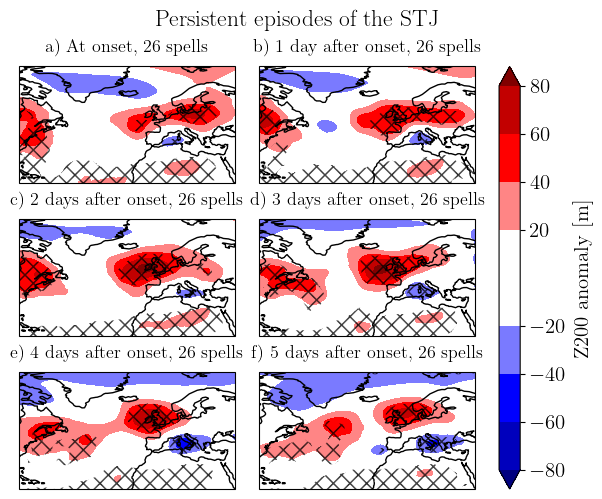

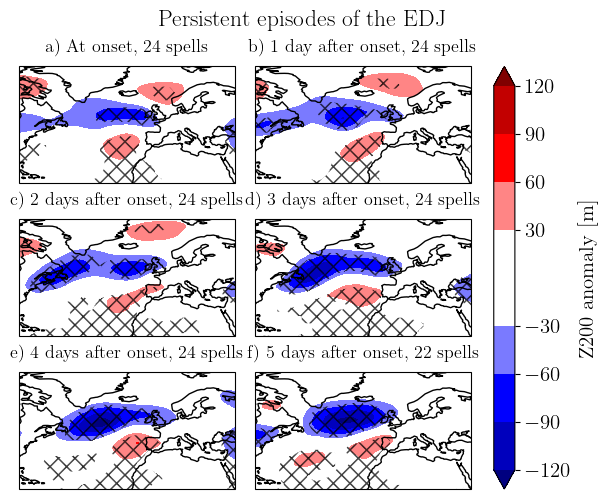

In [24]:
from string import ascii_lowercase
plt.rc("axes", titlesize=13)
da = da_z200_anom.copy()
cmap = colormaps.BlWhRe
plot_kwargs = {"cmap": cmap, "levels": 7}
Path(f"{FIGURES}/jet_persistence/realspace_stuff").mkdir(exist_ok=True)
nrow, ncol = 3, 2
n = nrow * ncol
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    clu = Clusterplot(nrow, ncol, get_region(da))
    spells_from_jet_daily = daily_spells_list[jet]
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for i in range(n):
        letter = ascii_lowercase[i % len(ascii_lowercase)]
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")==i)
        mask[:, i] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        title_0 = f"{i} day{'s' if i > 1 else ''} after onset" if i > 0 else "At onset"
        titles.append(f"{letter}) {title_0}, {n_spells} spells")
    _ = clu.add_any_contour_from_mask(da, mask, stippling=True, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
    clu.fig.suptitle(f"Persistent episodes of the {jet[:3]}")
    # clu.resize_relative([1.1, 1])
    # clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/{da.name}_realspace_{jet}.png")
    # plt.close()

100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


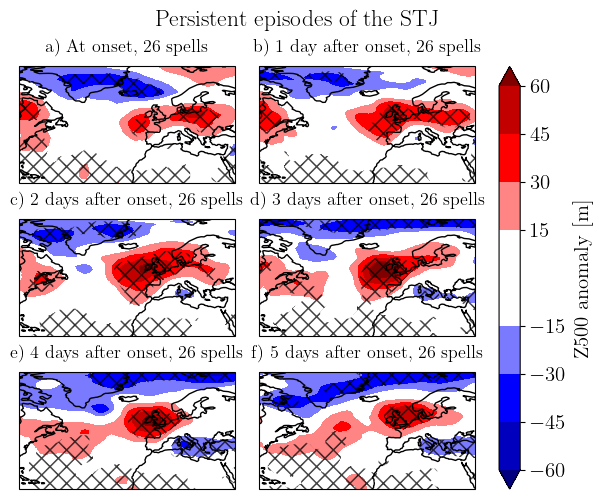

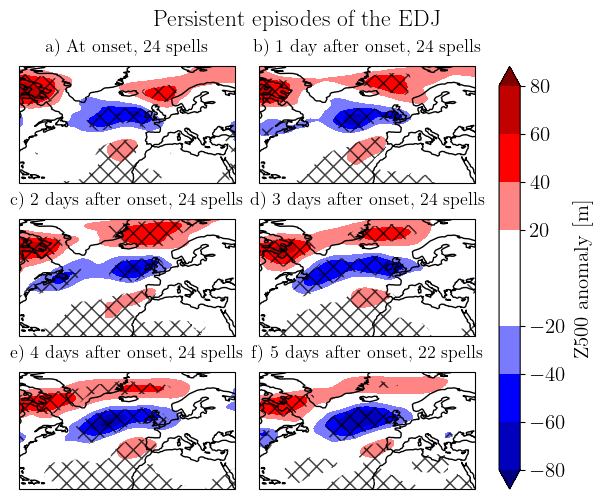

In [25]:
from string import ascii_lowercase
plt.rc("axes", titlesize=13)
da = da_z500_anom.copy()
cmap = colormaps.BlWhRe
plot_kwargs = {"cmap": cmap, "levels": 7}
Path(f"{FIGURES}/jet_persistence/realspace_stuff").mkdir(exist_ok=True)
nrow, ncol = 3, 2
n = nrow * ncol
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    clu = Clusterplot(nrow, ncol, get_region(da))
    spells_from_jet_daily = daily_spells_list[jet]
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for i in range(n):
        letter = ascii_lowercase[i % len(ascii_lowercase)]
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")==i)
        mask[:, i] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        title_0 = f"{i} day{'s' if i > 1 else ''} after onset" if i > 0 else "At onset"
        titles.append(f"{letter}) {title_0}, {n_spells} spells")
    _ = clu.add_any_contour_from_mask(da, mask, stippling=True, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
    clu.fig.suptitle(f"Persistent episodes of the {jet[:3]}")

In [35]:
plt.rc("axes", titlesize=13)
da = da_theta2pvu.copy()
cmap = colormaps.amp
plot_kwargs = {"cmap": cmap, "levels": MaxNLocator(11).tick_values(300, 380).tolist()}

nrow, ncol = 14, 2
n = nrow * ncol
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    clu = Clusterplot(nrow, ncol, get_region(da))
    spells_from_jet_daily = extend_spells(spells_list[jet], time_before=datetime.timedelta(days=1))
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for j in range(n):
        letter = ascii_lowercase[i % len(ascii_lowercase)]
        i = j - 4
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")== i)
        mask[:, j] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        title_0 = f"{np.abs(i)} step{'s' if np.abs(i) > 1 else ''} {'after' if i > 0 else 'before'} onset" if i != 0 else "At onset"
        titles.append(f"{letter}) {title_0}, {n_spells} spells")
    _ = clu.add_any_contour_from_mask(da, mask, stippling=False, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
    _ = clu.add_any_contour_from_mask(da_s, mask, levels=[25, 35], type="contour", linewidths=2., colors=["green"])    
    masked_da = []
    time_name = "time"
    reduction_function = np.nanmean
    for mas in mask.T:
        masked_da.append(ds.sel(time=ds.time.dt.month.isin([6, 7, 8, 9])).isel({time_name: mas}).reduce(reduction_function, dim=time_name))
    masked_da = xr.concat(masked_da, dim="relative_index").assign_coords(relative_index=np.arange(n) - 4)
    jets_on_mean = find_all_jets(masked_da)
    for j in range(n):
        i = j - 4
        lo, la = jets_on_mean.filter(pl.col("relative_index") == i)[["lon", "lat"]]
        clu.axes[j].scatter(lo - clu.central_longitude, la, marker="x", s=10, color=COLORS[1])
    clu.fig.suptitle(f"Persistent episodes of the {jet[:3]}")
    clu.resize_relative([1.1, 1])
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/{da.name}_realspace_{jet}.png")
    plt.close()

100%|██████████| 28/28 [00:00<00:00, 329.03it/s]


In [36]:
plt.rc("axes", titlesize=13)
da = da_theta2pvu_anom.copy()
cmap = colormaps.BlWhRe
plot_kwargs = {"cmap": cmap, "levels": np.arange(-8, 10, 2).tolist()}

nrow, ncol = 14, 2
n = nrow * ncol
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    clu = Clusterplot(nrow, ncol, get_region(da))
    spells_from_jet_daily = extend_spells(spells_list[jet], time_before=datetime.timedelta(days=1))
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for j in range(n):
        letter = ascii_lowercase[i % len(ascii_lowercase)]
        i = j - 4
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")== i)
        mask[:, j] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        title_0 = f"{np.abs(i)} step{'s' if np.abs(i) > 1 else ''} {'after' if i > 0 else 'before'} onset" if i != 0 else "At onset"
        titles.append(f"{letter}) {title_0}, {n_spells} spells")
    _ = clu.add_any_contour_from_mask(da, mask, stippling=False, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
    masked_da = []
    time_name = "time"
    reduction_function = np.mean
    for mas in mask.T:
        masked_da.append(ds.sel(time=ds.time.dt.month.isin([6, 7, 8, 9])).isel({time_name: mas}).reduce(reduction_function, dim=time_name))
    masked_da = xr.concat(masked_da, dim="relative_index").assign_coords(relative_index=np.arange(n) - 4)
    jets_on_mean = find_all_jets(masked_da)
    for j in range(n):
        i = j - 4
        lo, la = jets_on_mean.filter(pl.col("relative_index") == i)[["lon", "lat"]]
        clu.axes[j].scatter(lo - clu.central_longitude, la, marker="x", s=10, color="black")
    clu.fig.suptitle(f"Persistent episodes of the {jet[:3]}")
    clu.resize_relative([1.1, 1])
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/{da.name}_anom_realspace_{jet}.png")
    plt.close()

100%|██████████| 28/28 [00:00<00:00, 324.17it/s]


In [37]:
da = da_tp_anom.copy().sel(lon=slice(-10, 40), lat=slice(30, 70)) * 1000
cmap = colormaps.BlWhRe
plot_kwargs = {
    "cmap": colormaps.precip4_diff_19lev,
    "levels": 13,
    "q": 0.999,
    "transparify": 0,
}
nrow, ncol = 3, 2
n = nrow * ncol
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    clu = Clusterplot(nrow, ncol, get_region(da))
    spells_from_jet_daily = daily_spells_list[jet]
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for i in range(n):
        letter = ascii_lowercase[i % len(ascii_lowercase)]
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")==i)
        mask[:, i] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        title_0 = f"{i} day{'s' if i > 1 else ''} after onset" if i > 0 else "At onset"
        titles.append(f"{letter}) {title_0}, {n_spells} spells")
    _ = clu.add_any_contour_from_mask(da, mask, stippling=True, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
    clu.fig.suptitle(f"Persistent episodes of the {jet[:3]}")
    clu.resize_relative([1.1, 1])
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/{da.name}_realspace_{jet}.png")
    plt.close()

100%|██████████| 6/6 [00:00<00:00, 17.89it/s]


## Individual spells

In [44]:
plt.rc("axes", titlesize=13)
da = da_theta2pvu.copy()
cmap = colormaps.amp
plot_kwargs = {"cmap": cmap, "levels": MaxNLocator(11).tick_values(da.quantile(0.05), da.quantile(0.99)).tolist()}

nrow, ncol = 10, 2
n = nrow * ncol
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    spells_from_jet_daily = extend_spells(spells_list[jet], time_before=datetime.timedelta(days=1))
    for huh, spell in spells_from_jet_daily.group_by("spell", maintain_order=True):
        spell = spell.filter(pl.col("relative_index") <= n - 4)
        titles = spell["time"].dt.to_string("%Y-%m-%dT%H:%M").to_list()
        titles = [f"{ascii_lowercase[i]}) {title}" for i, title in enumerate(titles)]
        clu = Clusterplot(nrow, ncol, get_region(da), row_height=3.5)
        to_plot = da.sel(time=spell["time"])
        clu.add_contourf(to_plot, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
        for i, t in enumerate(spell["time"]):
            lo, la, is_p = phat_jets.filter(pl.col("time") == t)[["lon", "lat", "is_polar"]]
            try:
                clu.axes[i].scatter(lo - clu.central_longitude, la, c=is_p, vmin=0, vmax=1, cmap=colormaps.cet_l_bmw_r, marker="x", s=10)
            except IndexError:
                continue
        clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/indiv_spells/{da.name}_realspace_{jet}_spell{huh[0]}.png")
        plt.close()

In [ ]:
plt.rc("axes", titlesize=13)
da = da_theta2pvu_anom.copy()
cmap = colormaps.BlWhRe
plot_kwargs = {"cmap": cmap, "levels": np.arange(-12, 14, 2).tolist()}

nrow, ncol = 10, 2
n = nrow * ncol
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    spells_from_jet_daily = extend_spells(spells_list[jet], time_before=datetime.timedelta(days=1))
    for huh, spell in spells_from_jet_daily.group_by("spell", maintain_order=True):
        spell = spell.filter(pl.col("relative_index") <= n - 4)
        titles = spell["time"].dt.to_string("%Y-%m-%dT%H:%M").to_list()
        titles = [f"{ascii_lowercase[i]}) {title}" for i, title in enumerate(titles)]
        clu = Clusterplot(nrow, ncol, get_region(da), row_height=3.5)
        to_plot = da.sel(time=spell["time"])
        clu.add_contourf(to_plot, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
        for i, t in enumerate(spell["time"]):
            lo, la, is_p = phat_jets.filter(pl.col("time") == t)[["lon", "lat", "is_polar"]]
            try:
                clu.axes[i].scatter(lo - clu.central_longitude, la, color="black", marker="x", s=10)
            except IndexError:
                continue
        clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/indiv_spells/{da.name}_anom_realspace_{jet}_spell{huh[0]}.png")
        plt.close()

In [43]:
plt.rc("axes", titlesize=13)
da = da_T_anom.copy()
cmap = colormaps.BlWhRe
plot_kwargs = {"cmap": cmap, "levels": np.arange(-8, 10, 2).tolist()}

nrow, ncol = 4, 2
n = nrow * ncol
for jet in spells_list:
    if jet[-4:] != "catd":
        continue
    spells_from_jet_daily = extend_spells(daily_spells_list[jet], time_before=datetime.timedelta(days=2))
    for huh, spell in spells_from_jet_daily.group_by("spell", maintain_order=True):
        spell = spell.filter(pl.col("relative_index") <= n - 2)
        titles = spell["time"].dt.to_string("%Y-%m-%dT%H:%M").to_list()
        titles = [f"{ascii_lowercase[i]}) {title}" for i, title in enumerate(titles)]
        clu = Clusterplot(nrow, ncol, get_region(da), row_height=3.5)
        to_plot = da.sel(time=spell["time"])
        clu.add_contourf(to_plot, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
        for i, t in enumerate(spell["time"]):
            lo, la, is_p = phat_jets.filter(pl.col("time") == t)[["lon", "lat", "is_polar"]]
            try:
                clu.axes[i].scatter(lo - clu.central_longitude, la, color="black", marker="x", s=10)
            except IndexError:
                continue
        clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/indiv_spells/{da.name}_anom_realspace_{jet}_spell{huh[0]}.png")
        plt.close()

#